In [1]:
# Import essential packages
import os
import math
import numpy as np
import matplotlib.pyplot as plt

# Import tomography and imaging packages
import tomopy
from skimage.transform import rotate, AffineTransform
from skimage import transform as tf
from scipy.fft import fft2, fftshift
from scipy.signal import correlate

# Import neural net packages
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.profiler
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
from torchinfo import summary

In [2]:
# Checking to ensure environment and cuda are correct
print("Working Environment: {}".format(os.environ['CONDA_DEFAULT_ENV']))
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
print("Cuda Version: {}".format(torch.version.cuda))
print("Cuda Availability: {}".format(torch.cuda.is_available()))
!pwd

Working Environment: pytorch
Cuda Version: 11.8
Cuda Availability: True
/home/liam/Projects/Tomographic Alignment


In [3]:
def crosscorr_reprojection(data, entries):
    
    ang = tomopy.angles(data[0][0][0, 0].shape[0])
    _rec = 1e-12 * np.ones((data[0][0][0, 0].shape[1], data[0][0][0, 0].shape[2], data[0][0][0, 0].shape[2]))
    data_copy = data.copy()
    out_data = np.zeros((entries, 2), dtype = object)
    
    for i in range (entries):
    
        out_data[i, 0] = np.zeros((1, 1, data[0][0][0, 0].shape[0], data[0][0][0, 0].shape[1] * 2 - 1,
                                      data[0][0][0, 0].shape[2] * 2 - 1))
        out_data[i, 1] = data_copy[i, 1]
        
        rec = tomopy.recon(data_copy[i][0][0, 0], ang, center = None, 
                            algorithm = 'mlem', init_recon = _rec)
        reproj = tomopy.project(rec, ang, center = None, pad = False)
        
        for j in range (data[0][0][0, 0].shape[0]):
            
            out_data[i, 0][0, 0, j] = correlate(data_copy[i][0][0, 0, j], reproj[j], method = 'fft')
        
    return out_data

In [4]:
def to_projections(data, entries):
    
    projections = np.zeros((entries * data[0][0][0, 0].shape[0], 2), dtype = object)

    for i in range (entries):

        for j in range (data[0][0][0, 0].shape[0]):

            projections[i * data[0][0][0, 0].shape[0] + j, 0] = data[i, 0][0, 0, j, :, :]
            projections[i * data[0][0][0, 0].shape[0] + j, 1] = np.asarray([data[i, 1][0, 2 * j], 
                                                                            data[i, 1][0, 2 * j + 1]])
            
    return projections

In [5]:
# Loading data, 25 entries of 128 resolution shepp3ds
res = 128
entries = 250
data = []

for i in range(entries):
    data.append(np.load('./shepp{}-{}/shepp{}-{}_{}.npy'.format(res, entries, res, entries, i), 
                        allow_pickle = True))
    
data = np.asarray(data)
angles = entries * data[0][0][0, 0].shape[0]
print("Total Projections: {}".format(angles))
crosscorr_reproj = crosscorr_reprojection(data, entries)
crosscorr_data = to_projections(crosscorr_reproj, entries)

Total Projections: 45000


In [6]:
for i in range (crosscorr_data.shape[0]):
    
    crosscorr_data[i, 0] = np.expand_dims(crosscorr_data[i, 0], axis = 0)
    crosscorr_data[i, 0] = np.expand_dims(crosscorr_data[i, 0], axis = 0)
    crosscorr_data[i, 1] = np.expand_dims(crosscorr_data[i, 1], axis = 0)
    
print(crosscorr_data.shape)
print(crosscorr_data[0, 0].shape)
print(crosscorr_data[0, 1].shape)

(45000, 2)
(1, 1, 255, 367)
(1, 2)


In [7]:
# Checking shape of training and testing splits
trainset, testset = np.split(crosscorr_data, [int(angles * 4 / 5)])
print("Shape of Training Dataset: {}".format(trainset.shape))
print("Shape of Testing Dataset: {}".format(testset.shape))

Shape of Training Dataset: (36000, 2)
Shape of Testing Dataset: (9000, 2)


In [8]:
# Normalize data
def norm(proj):
    proj = (proj - torch.min(proj)) / (torch.max(proj) - torch.min(proj))
    return proj

# Get inplanes for resnet
def get_inplanes():
    return [64, 128, 256, 512]


# Preset for a 3x3 kernel convolution
def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes,
                     out_planes,
                     kernel_size=3,
                     stride=stride,
                     padding=1,
                     bias=False)


# Preset for a 1x1 kernel convolution
def conv1x1(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes,
                     out_planes,
                     kernel_size=1,
                     stride=stride,
                     bias=False)

# Basic block for resnet
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, downsample=None):
        super().__init__()

        self.conv1 = conv3x3(in_planes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out
    
# Bottleneck block for resnet
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1, downsample=None):
        super().__init__()

        self.conv1 = conv1x1(in_planes, planes)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes, stride)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = conv1x1(planes, planes * self.expansion)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out
    

# Resnet structure
class ResNet(nn.Module):

    def __init__(self,
                 block,
                 layers,
                 block_inplanes,
                 n_input_channels=1,
                 conv1_t_size=7,
                 conv1_t_stride=1,
                 no_max_pool=False,
                 shortcut_type='B',
                 widen_factor=1.0,
                 n_classes=2):
        super().__init__()

        block_inplanes = [int(x * widen_factor) for x in block_inplanes]

        self.in_planes = block_inplanes[0]
        self.no_max_pool = no_max_pool

        self.conv1 = nn.Conv2d(n_input_channels,
                               self.in_planes,
                               kernel_size=(conv1_t_size, 7),
                               stride=(conv1_t_stride, 2),
                               padding=(conv1_t_size // 2, 3),
                               bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_planes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, block_inplanes[0], layers[0],
                                       shortcut_type)
        self.layer2 = self._make_layer(block,
                                       block_inplanes[1],
                                       layers[1],
                                       shortcut_type,
                                       stride=2)
        self.layer3 = self._make_layer(block,
                                       block_inplanes[2],
                                       layers[2],
                                       shortcut_type,
                                       stride=2)
        self.layer4 = self._make_layer(block,
                                       block_inplanes[3],
                                       layers[3],
                                       shortcut_type,
                                       stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(block_inplanes[3] * block.expansion, n_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight,
                                        mode='fan_out',
                                        nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _downsample_basic_block(self, x, planes, stride):
        out = F.avg_pool2d(x, kernel_size=1, stride=stride)
        zero_pads = torch.zeros(out.size(0), planes - out.size(1), out.size(2),
                                out.size(3), out.size(4))
        if isinstance(out.data, torch.cuda.FloatTensor):
            zero_pads = zero_pads.cuda()

        out = torch.cat([out.data, zero_pads], dim=1)

        return out

    # make layer helper function
    def _make_layer(self, block, planes, blocks, shortcut_type, stride=1):
        downsample = None
        if stride != 1 or self.in_planes != planes * block.expansion:
            
                downsample = nn.Sequential(
                    conv1x1(self.in_planes, planes * block.expansion, stride),
                    nn.BatchNorm2d(planes * block.expansion))

        layers = []
        layers.append(
            block(in_planes=self.in_planes,
                  planes=planes,
                  stride=stride,
                  downsample=downsample))
        self.in_planes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.in_planes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        
        x = norm(x)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        if not self.no_max_pool:
            x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)

        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x


# Generates form of resnet
def generate_model(model_depth, **kwargs):
    assert model_depth in [10, 18, 34, 50, 101, 152, 200]

    if model_depth == 10:
        model = ResNet(BasicBlock, [1, 1, 1, 1], get_inplanes(), **kwargs)
    elif model_depth == 18:
        model = ResNet(BasicBlock, [2, 2, 2, 2], get_inplanes(), **kwargs)
    elif model_depth == 34:
        model = ResNet(BasicBlock, [3, 4, 6, 3], get_inplanes(), **kwargs)
    elif model_depth == 50:
        model = ResNet(Bottleneck, [3, 4, 6, 3], get_inplanes(), **kwargs)
    elif model_depth == 101:
        model = ResNet(Bottleneck, [3, 4, 23, 3], get_inplanes(), **kwargs)
    elif model_depth == 152:
        model = ResNet(Bottleneck, [3, 8, 36, 3], get_inplanes(), **kwargs)
    elif model_depth == 200:
        model = ResNet(Bottleneck, [3, 24, 36, 3], get_inplanes(), **kwargs)

    return model

In [9]:
model = generate_model(18)
summary(model, (1, 1, 255, 367))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 2]                    --
├─Conv2d: 1-1                            [1, 64, 255, 184]         3,136
├─BatchNorm2d: 1-2                       [1, 64, 255, 184]         128
├─ReLU: 1-3                              [1, 64, 255, 184]         --
├─MaxPool2d: 1-4                         [1, 64, 128, 92]          --
├─Sequential: 1-5                        [1, 64, 128, 92]          --
│    └─BasicBlock: 2-1                   [1, 64, 128, 92]          --
│    │    └─Conv2d: 3-1                  [1, 64, 128, 92]          36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 128, 92]          128
│    │    └─ReLU: 3-3                    [1, 64, 128, 92]          --
│    │    └─Conv2d: 3-4                  [1, 64, 128, 92]          36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 128, 92]          128
│    │    └─ReLU: 3-6                    [1, 64, 128, 92]          --
│

In [10]:
# Clear CUDA cache
torch.cuda.empty_cache()
print("Cleared Cache")

# Train the model

# Create writer and profiler to analyze loss over each epoch
# writer = SummaryWriter()

# Set device to CUDA if available, initialize model
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Device: {}'.format(device))
net = generate_model(18)
net.to(device)

# Set up optimizer and loss function, set number of epochs
optimizer = optim.SGD(net.parameters(), lr = 1e-2, momentum=0.9, weight_decay = 0)
criterion = nn.MSELoss(reduction = 'mean')
criterion.to(device)
num_epochs = 2500

# Iniitializing variables to show statistics
iteration = 0
test_iteration = 0
loss_list = []
test_loss_list = []
epoch_loss_averages = []
test_epoch_loss_averages = []

# Iterates over dataset multiple times
for epoch in range(num_epochs):
    
    epoch_loss = 0
    test_epoch_loss = 0
    
    for i, data in enumerate(trainset, 0):
        
        inputs, truths = norm(torch.from_numpy(data[0]).to(device).float()), torch.from_numpy(data[1]).to(device).float()
        optimizer.zero_grad()

        outputs = net(inputs).to(device)
        loss = criterion(outputs, truths)
        # writer.add_scalar("Loss / Train", loss, epoch) # adds training loss scalar
        loss_list.append(loss.cpu().detach().numpy())
        epoch_loss += loss.cpu().detach().numpy()
        loss.backward()
        optimizer.step()

        iteration += 1
        if iteration % trainset.shape[0] == 0:
            epoch_loss_averages.append(epoch_loss / trainset.shape[0])
            print('Epoch: {}   Training Loss:   {} '.format(epoch, epoch_loss / trainset.shape[0]))
            
    for i, test_data in enumerate(testset, 0):
        
        inputs, truths = norm(torch.from_numpy(test_data[0]).to(device).float()), torch.from_numpy(test_data[1]).to(device).float()
        outputs = net(inputs).to(device)
        test_loss = criterion(outputs, truths)
        
        # writer.add_scalar("Loss / Test", test_loss, epoch) # adds testing loss scalar
        test_loss_list.append(test_loss.cpu().detach().numpy())
        test_epoch_loss += test_loss.cpu().detach().numpy()
        
        test_iteration +=1
        if test_iteration % testset.shape[0] == 0:
            test_epoch_loss_averages.append(test_epoch_loss / testset.shape[0])
            print('Epoch: {}   Validation Loss: {} '.format(epoch, test_epoch_loss / testset.shape[0]))
            
# writer.flush()
# writer.close()

Cleared Cache
Device: cuda:0
Epoch: 0   Training Loss: 9.001903265839102 
Epoch: 0   Validation Loss: 8.718365011807117 
Epoch: 1   Training Loss: 8.977343308366933 
Epoch: 1   Validation Loss: 8.718365464013484 
Epoch: 2   Training Loss: 8.977343272391584 
Epoch: 2   Validation Loss: 8.718365976444135 
Epoch: 3   Training Loss: 8.977342571284499 
Epoch: 3   Validation Loss: 8.718367257598167 
Epoch: 4   Training Loss: 8.977342513580778 
Epoch: 4   Validation Loss: 8.718368900542664 
Epoch: 5   Training Loss: 8.977342381711388 
Epoch: 5   Validation Loss: 8.718369437027102 
Epoch: 6   Training Loss: 8.97734225643324 
Epoch: 6   Validation Loss: 8.718369257967298 
Epoch: 7   Training Loss: 8.977342362506914 
Epoch: 7   Validation Loss: 8.718370199143887 
Epoch: 8   Training Loss: 8.977343134102437 
Epoch: 8   Validation Loss: 8.718371050827827 
Epoch: 9   Training Loss: 8.977342989075142 
Epoch: 9   Validation Loss: 8.718372612374525 
Epoch: 10   Training Loss: 8.977341343335684 
Epoch:

Epoch: 87   Validation Loss: 8.718643072041372 
Epoch: 88   Training Loss: 8.977253435362378 
Epoch: 88   Validation Loss: 8.71860249443673 
Epoch: 89   Training Loss: 8.977270975116845 
Epoch: 89   Validation Loss: 8.718621856703733 
Epoch: 90   Training Loss: 8.97729793613489 
Epoch: 90   Validation Loss: 8.718660972104201 
Epoch: 91   Training Loss: 8.97746873829951 
Epoch: 91   Validation Loss: 8.718699273117922 
Epoch: 92   Training Loss: 8.977177918077167 
Epoch: 92   Validation Loss: 8.719000683095409 
Epoch: 93   Training Loss: 8.977211561076711 
Epoch: 93   Validation Loss: 8.718743552230091 
Epoch: 94   Training Loss: 8.977214862345614 
Epoch: 94   Validation Loss: 8.718858965626504 
Epoch: 95   Training Loss: 8.977155940180728 
Epoch: 95   Validation Loss: 8.718931093799675 
Epoch: 96   Training Loss: 8.97714275480105 
Epoch: 96   Validation Loss: 8.718822850619857 
Epoch: 97   Training Loss: 8.977147237874153 
Epoch: 97   Validation Loss: 8.718960802335499 
Epoch: 98   Trai

Epoch: 173   Validation Loss: 8.718699540746398 
Epoch: 174   Training Loss: 8.97708535436568 
Epoch: 174   Validation Loss: 8.72009408580698 
Epoch: 175   Training Loss: 8.97711379629542 
Epoch: 175   Validation Loss: 8.718429277019782 
Epoch: 176   Training Loss: 8.977175784117703 
Epoch: 176   Validation Loss: 8.720492665182592 
Epoch: 177   Training Loss: 8.976805421115095 
Epoch: 177   Validation Loss: 8.720462768891723 
Epoch: 178   Training Loss: 8.976875721423745 
Epoch: 178   Validation Loss: 8.718455802553747 
Epoch: 179   Training Loss: 8.977180995204957 
Epoch: 179   Validation Loss: 8.71845851636057 
Epoch: 180   Training Loss: 8.977329874640409 
Epoch: 180   Validation Loss: 8.718447177764132 
Epoch: 181   Training Loss: 8.977119743026101 
Epoch: 181   Validation Loss: 8.718411347275083 
Epoch: 182   Training Loss: 8.977002310691049 
Epoch: 182   Validation Loss: 8.720462442034648 
Epoch: 183   Training Loss: 8.977110330473936 
Epoch: 183   Validation Loss: 8.718422844519

Epoch: 259   Validation Loss: 8.720177161041025 
Epoch: 260   Training Loss: 8.977106036762212 
Epoch: 260   Validation Loss: 8.718577266745891 
Epoch: 261   Training Loss: 8.977192626370737 
Epoch: 261   Validation Loss: 8.71919879960662 
Epoch: 262   Training Loss: 8.977139465875155 
Epoch: 262   Validation Loss: 8.718889824909676 
Epoch: 263   Training Loss: 8.9770374406288 
Epoch: 263   Validation Loss: 8.71949489524143 
Epoch: 264   Training Loss: 8.976944022804528 
Epoch: 264   Validation Loss: 8.71951127211139 
Epoch: 265   Training Loss: 8.976845075036442 
Epoch: 265   Validation Loss: 8.71989746026643 
Epoch: 266   Training Loss: 8.976799015360536 
Epoch: 266   Validation Loss: 8.719596117079982 
Epoch: 267   Training Loss: 8.976903175176114 
Epoch: 267   Validation Loss: 8.719474233020097 
Epoch: 268   Training Loss: 8.976731713631034 
Epoch: 268   Validation Loss: 8.719741627762922 
Epoch: 269   Training Loss: 8.976732938412116 
Epoch: 269   Validation Loss: 8.71914762566156

Epoch: 345   Validation Loss: 8.720129074762266 
Epoch: 346   Training Loss: 8.973227328142743 
Epoch: 346   Validation Loss: 8.722153338140757 
Epoch: 347   Training Loss: 8.973080901892565 
Epoch: 347   Validation Loss: 8.724106038008506 
Epoch: 348   Training Loss: 8.972986118176738 
Epoch: 348   Validation Loss: 8.724294354469464 
Epoch: 349   Training Loss: 8.973419308788868 
Epoch: 349   Validation Loss: 8.723737346051701 
Epoch: 350   Training Loss: 8.973039489824496 
Epoch: 350   Validation Loss: 8.723313133075937 
Epoch: 351   Training Loss: 8.972288680793193 
Epoch: 351   Validation Loss: 8.723848817508824 
Epoch: 352   Training Loss: 8.972965576584693 
Epoch: 352   Validation Loss: 8.725830072685456 
Epoch: 353   Training Loss: 8.972442745691358 
Epoch: 353   Validation Loss: 8.726725774928047 
Epoch: 354   Training Loss: 8.972637951311253 
Epoch: 354   Validation Loss: 8.725299418488518 
Epoch: 355   Training Loss: 8.973129309950872 
Epoch: 355   Validation Loss: 8.72397719

Epoch: 431   Validation Loss: 8.72007622487129 
Epoch: 432   Training Loss: 8.97487148769237 
Epoch: 432   Validation Loss: 8.720390409059926 
Epoch: 433   Training Loss: 8.97415393070633 
Epoch: 433   Validation Loss: 8.715535508913712 
Epoch: 434   Training Loss: 8.974400795107304 
Epoch: 434   Validation Loss: 8.716847402211796 
Epoch: 435   Training Loss: 8.97374934457938 
Epoch: 435   Validation Loss: 8.719075705383155 
Epoch: 436   Training Loss: 8.974837872443826 
Epoch: 436   Validation Loss: 8.717231906341182 
Epoch: 437   Training Loss: 8.972759203659423 
Epoch: 437   Validation Loss: 8.718619949341182 
Epoch: 438   Training Loss: 8.971730591644231 
Epoch: 438   Validation Loss: 8.718715928366356 
Epoch: 439   Training Loss: 8.97153956791604 
Epoch: 439   Validation Loss: 8.718716736319527 
Epoch: 440   Training Loss: 8.971747213988378 
Epoch: 440   Validation Loss: 8.722121709945922 
Epoch: 441   Training Loss: 8.972039109313137 
Epoch: 441   Validation Loss: 8.7221724106151

Epoch: 517   Validation Loss: 8.725379034369615 
Epoch: 518   Training Loss: 8.959587072209278 
Epoch: 518   Validation Loss: 8.726532616308269 
Epoch: 519   Training Loss: 8.955193111665244 
Epoch: 519   Validation Loss: 8.729063471511719 
Epoch: 520   Training Loss: 8.95195080623684 
Epoch: 520   Validation Loss: 8.728506004549187 
Epoch: 521   Training Loss: 8.947522322347364 
Epoch: 521   Validation Loss: 8.72968468786807 
Epoch: 522   Training Loss: 8.945876481588218 
Epoch: 522   Validation Loss: 8.729061761036386 
Epoch: 523   Training Loss: 8.956566475569634 
Epoch: 523   Validation Loss: 8.729106492074969 
Epoch: 524   Training Loss: 8.942866145753168 
Epoch: 524   Validation Loss: 8.729067409675736 
Epoch: 525   Training Loss: 8.955799275555838 
Epoch: 525   Validation Loss: 8.727367305048343 
Epoch: 526   Training Loss: 8.951884962399046 
Epoch: 526   Validation Loss: 8.726324553536976 
Epoch: 527   Training Loss: 8.950869360442093 
Epoch: 527   Validation Loss: 8.7199273621

Epoch: 603   Validation Loss: 8.753781889248083 
Epoch: 604   Training Loss: 8.846838541169197 
Epoch: 604   Validation Loss: 8.754795235908745 
Epoch: 605   Training Loss: 8.84551049676172 
Epoch: 605   Validation Loss: 8.74942390495101 
Epoch: 606   Training Loss: 8.828560829173792 
Epoch: 606   Validation Loss: 8.754681283268368 
Epoch: 607   Training Loss: 8.935316992813036 
Epoch: 607   Validation Loss: 8.71933160097359 
Epoch: 608   Training Loss: 8.9702792369593 
Epoch: 608   Validation Loss: 8.722853758213505 
Epoch: 609   Training Loss: 8.963881970456146 
Epoch: 609   Validation Loss: 8.728239702423 
Epoch: 610   Training Loss: 8.95906976622301 
Epoch: 610   Validation Loss: 8.7292130025766 
Epoch: 611   Training Loss: 8.956063184958262 
Epoch: 611   Validation Loss: 8.72267239482461 
Epoch: 612   Training Loss: 8.952207510898033 
Epoch: 612   Validation Loss: 8.724816275576725 
Epoch: 613   Training Loss: 8.962085048444303 
Epoch: 613   Validation Loss: 8.722909136776657 
Epo

Epoch: 689   Validation Loss: 8.722062686590029 
Epoch: 690   Training Loss: 8.9693762349682 
Epoch: 690   Validation Loss: 8.724586628561504 
Epoch: 691   Training Loss: 8.967065085859783 
Epoch: 691   Validation Loss: 8.722351984514466 
Epoch: 692   Training Loss: 8.963497950842209 
Epoch: 692   Validation Loss: 8.72541066507853 
Epoch: 693   Training Loss: 8.957126201770537 
Epoch: 693   Validation Loss: 8.727895842977807 
Epoch: 694   Training Loss: 8.953494436816833 
Epoch: 694   Validation Loss: 8.73009993499306 
Epoch: 695   Training Loss: 8.953780636921175 
Epoch: 695   Validation Loss: 8.735941375808688 
Epoch: 696   Training Loss: 8.945428457214723 
Epoch: 696   Validation Loss: 8.727665818349957 
Epoch: 697   Training Loss: 8.941174303758519 
Epoch: 697   Validation Loss: 8.721646296160337 
Epoch: 698   Training Loss: 8.964925942028403 
Epoch: 698   Validation Loss: 8.723220464513442 
Epoch: 699   Training Loss: 8.958122871134803 
Epoch: 699   Validation Loss: 8.724984785142

Epoch: 775   Validation Loss: 8.726481136456307 
Epoch: 776   Training Loss: 8.964703515597133 
Epoch: 776   Validation Loss: 8.732400385558789 
Epoch: 777   Training Loss: 8.961528243600036 
Epoch: 777   Validation Loss: 8.74195577854117 
Epoch: 778   Training Loss: 8.949440297472002 
Epoch: 778   Validation Loss: 8.755990929274716 
Epoch: 779   Training Loss: 8.935953386429805 
Epoch: 779   Validation Loss: 8.781454235784453 
Epoch: 780   Training Loss: 8.925308527291563 
Epoch: 780   Validation Loss: 8.818936285221891 
Epoch: 781   Training Loss: 8.907393200276285 
Epoch: 781   Validation Loss: 8.885113915265054 
Epoch: 782   Training Loss: 8.885106747735808 
Epoch: 782   Validation Loss: 8.896632242636214 
Epoch: 783   Training Loss: 8.855309682683643 
Epoch: 783   Validation Loss: 8.965704152385996 
Epoch: 784   Training Loss: 8.836752152787506 
Epoch: 784   Validation Loss: 8.981008513840377 
Epoch: 785   Training Loss: 8.916403245608464 
Epoch: 785   Validation Loss: 9.094991880

Epoch: 861   Validation Loss: 9.774339623325067 
Epoch: 862   Training Loss: 8.647142602882969 
Epoch: 862   Validation Loss: 8.743152921036403 
Epoch: 863   Training Loss: 8.976628494166066 
Epoch: 863   Validation Loss: 8.758462939430506 
Epoch: 864   Training Loss: 8.96948645300326 
Epoch: 864   Validation Loss: 8.762615196710076 
Epoch: 865   Training Loss: 8.958830880371732 
Epoch: 865   Validation Loss: 8.771011549529648 
Epoch: 866   Training Loss: 8.946959293024827 
Epoch: 866   Validation Loss: 8.77447194399003 
Epoch: 867   Training Loss: 8.927477257780192 
Epoch: 867   Validation Loss: 8.797379499262224 
Epoch: 868   Training Loss: 8.913710065871879 
Epoch: 868   Validation Loss: 8.865736640697921 
Epoch: 869   Training Loss: 8.890820439037425 
Epoch: 869   Validation Loss: 8.963371532505223 
Epoch: 870   Training Loss: 8.881168577760866 
Epoch: 870   Validation Loss: 8.988198819978894 
Epoch: 871   Training Loss: 8.746129078367371 
Epoch: 871   Validation Loss: 8.7409315108

Epoch: 947   Validation Loss: 9.135374339479062 
Epoch: 948   Training Loss: 8.770447674401927 
Epoch: 948   Validation Loss: 9.281845174319539 
Epoch: 949   Training Loss: 8.72650478991152 
Epoch: 949   Validation Loss: 9.448599265189541 
Epoch: 950   Training Loss: 8.689458090712309 
Epoch: 950   Validation Loss: 9.310501658074545 
Epoch: 951   Training Loss: 8.670664813159561 
Epoch: 951   Validation Loss: 9.52102935021698 
Epoch: 952   Training Loss: 8.571125908402678 
Epoch: 952   Validation Loss: 9.664493780654798 
Epoch: 953   Training Loss: 8.509794423052082 
Epoch: 953   Validation Loss: 9.848209429213906 
Epoch: 954   Training Loss: 8.453915131275034 
Epoch: 954   Validation Loss: 9.629805906872022 
Epoch: 955   Training Loss: 8.376242675897545 
Epoch: 955   Validation Loss: 9.819638428733496 
Epoch: 956   Training Loss: 8.294407506274277 
Epoch: 956   Validation Loss: 9.942003891445191 
Epoch: 957   Training Loss: 8.269539116885813 
Epoch: 957   Validation Loss: 9.8442790982

Epoch: 1032   Validation Loss: 8.792257506976776 
Epoch: 1033   Training Loss: 8.846857736757183 
Epoch: 1033   Validation Loss: 8.813470022293687 
Epoch: 1034   Training Loss: 8.798749302223976 
Epoch: 1034   Validation Loss: 8.855231216491555 
Epoch: 1035   Training Loss: 8.747995204729396 
Epoch: 1035   Validation Loss: 8.865999082761228 
Epoch: 1036   Training Loss: 8.664487686189998 
Epoch: 1036   Validation Loss: 8.923000653199878 
Epoch: 1037   Training Loss: 8.589915018706508 
Epoch: 1037   Validation Loss: 9.01222015907563 
Epoch: 1038   Training Loss: 8.48357053277691 
Epoch: 1038   Validation Loss: 9.057968008052955 
Epoch: 1039   Training Loss: 8.40702009989555 
Epoch: 1039   Validation Loss: 9.145242708162638 
Epoch: 1040   Training Loss: 8.316369700371327 
Epoch: 1040   Validation Loss: 9.222836868356628 
Epoch: 1041   Training Loss: 8.172643016056343 
Epoch: 1041   Validation Loss: 9.334133630181848 
Epoch: 1042   Training Loss: 8.029899548952843 
Epoch: 1042   Validatio

Epoch: 1116   Validation Loss: 11.594014985544938 
Epoch: 1117   Training Loss: 5.750692718264654 
Epoch: 1117   Validation Loss: 11.50271164831374 
Epoch: 1118   Training Loss: 5.535343591044143 
Epoch: 1118   Validation Loss: 10.186482177142551 
Epoch: 1119   Training Loss: 5.3228286709994626 
Epoch: 1119   Validation Loss: 10.204103901406775 
Epoch: 1120   Training Loss: 5.088768124737813 
Epoch: 1120   Validation Loss: 10.705107396346358 
Epoch: 1121   Training Loss: 4.801784763966574 
Epoch: 1121   Validation Loss: 10.797300100590695 
Epoch: 1122   Training Loss: 4.568955945868657 
Epoch: 1122   Validation Loss: 11.399245650168133 
Epoch: 1123   Training Loss: 4.3593320475332344 
Epoch: 1123   Validation Loss: 11.635092109606617 
Epoch: 1124   Training Loss: 4.150962179724158 
Epoch: 1124   Validation Loss: 11.444659297202552 
Epoch: 1125   Training Loss: 3.9500257491183404 
Epoch: 1125   Validation Loss: 11.296061095345378 
Epoch: 1126   Training Loss: 3.749685181130222 
Epoch: 1

Epoch: 1199   Validation Loss: 12.873776771063064 
Epoch: 1200   Training Loss: 1.5667263416353052 
Epoch: 1200   Validation Loss: 12.973824763397696 
Epoch: 1201   Training Loss: 1.5445803252508108 
Epoch: 1201   Validation Loss: 12.75735128165039 
Epoch: 1202   Training Loss: 1.5446354488996443 
Epoch: 1202   Validation Loss: 12.812377917490776 
Epoch: 1203   Training Loss: 1.4860143624655402 
Epoch: 1203   Validation Loss: 12.818801179988142 
Epoch: 1204   Training Loss: 1.4716999188641566 
Epoch: 1204   Validation Loss: 12.428603153780465 
Epoch: 1205   Training Loss: 1.490041285968743 
Epoch: 1205   Validation Loss: 12.449157912623312 
Epoch: 1206   Training Loss: 1.440923587326856 
Epoch: 1206   Validation Loss: 12.648927251103089 
Epoch: 1207   Training Loss: 1.468038661368919 
Epoch: 1207   Validation Loss: 12.49580748110771 
Epoch: 1208   Training Loss: 1.4584610098753992 
Epoch: 1208   Validation Loss: 12.243272038957013 
Epoch: 1209   Training Loss: 1.4447559255619669 
Epoch

Epoch: 1282   Training Loss: 0.9020484410490933 
Epoch: 1282   Validation Loss: 12.22887662999669 
Epoch: 1283   Training Loss: 0.9130688801479565 
Epoch: 1283   Validation Loss: 12.268066294508909 
Epoch: 1284   Training Loss: 0.8989694625227871 
Epoch: 1284   Validation Loss: 12.046853919913895 
Epoch: 1285   Training Loss: 0.8927588285388991 
Epoch: 1285   Validation Loss: 12.140959097453209 
Epoch: 1286   Training Loss: 0.8984184591132067 
Epoch: 1286   Validation Loss: 12.063693856808609 
Epoch: 1287   Training Loss: 0.8953013842145601 
Epoch: 1287   Validation Loss: 11.972609215752001 
Epoch: 1288   Training Loss: 0.8721615567092373 
Epoch: 1288   Validation Loss: 12.131041852227877 
Epoch: 1289   Training Loss: 0.8624805778037481 
Epoch: 1289   Validation Loss: 12.088680622747594 
Epoch: 1290   Training Loss: 0.8538415878930886 
Epoch: 1290   Validation Loss: 12.367363878699994 
Epoch: 1291   Training Loss: 0.8604144904606944 
Epoch: 1291   Validation Loss: 11.995135473312079 
E

Epoch: 1364   Validation Loss: 12.12036752218942 
Epoch: 1365   Training Loss: 0.5946496691238707 
Epoch: 1365   Validation Loss: 12.477105084470667 
Epoch: 1366   Training Loss: 0.5848101996836444 
Epoch: 1366   Validation Loss: 12.343127807858341 
Epoch: 1367   Training Loss: 0.5744482324548905 
Epoch: 1367   Validation Loss: 12.570287237501654 
Epoch: 1368   Training Loss: 0.5820387238677247 
Epoch: 1368   Validation Loss: 12.513449001113859 
Epoch: 1369   Training Loss: 0.5748443813054986 
Epoch: 1369   Validation Loss: 12.738910667240331 
Epoch: 1370   Training Loss: 0.571275252083028 
Epoch: 1370   Validation Loss: 12.224190244010378 
Epoch: 1371   Training Loss: 0.5865628979636468 
Epoch: 1371   Validation Loss: 12.326066843978627 
Epoch: 1372   Training Loss: 0.5753379098671975 
Epoch: 1372   Validation Loss: 12.264742030653442 
Epoch: 1373   Training Loss: 0.5775915035542785 
Epoch: 1373   Validation Loss: 12.610412475835757 
Epoch: 1374   Training Loss: 0.5871625431624462 
Ep

Epoch: 1446   Validation Loss: 12.431824647898884 
Epoch: 1447   Training Loss: 0.41750475214377264 
Epoch: 1447   Validation Loss: 12.339910741681518 
Epoch: 1448   Training Loss: 0.41963472674271324 
Epoch: 1448   Validation Loss: 12.595481435514984 
Epoch: 1449   Training Loss: 0.4159391638127211 
Epoch: 1449   Validation Loss: 12.609722544363272 
Epoch: 1450   Training Loss: 0.4127194814044828 
Epoch: 1450   Validation Loss: 12.513107971964972 
Epoch: 1451   Training Loss: 0.4142852082496374 
Epoch: 1451   Validation Loss: 12.639126772840715 
Epoch: 1452   Training Loss: 0.4308059490805453 
Epoch: 1452   Validation Loss: 12.561556137399206 
Epoch: 1453   Training Loss: 0.41351141468590497 
Epoch: 1453   Validation Loss: 12.782931579363103 
Epoch: 1454   Training Loss: 0.40972043159298144 
Epoch: 1454   Validation Loss: 12.474515000172612 
Epoch: 1455   Training Loss: 0.40264459871261127 
Epoch: 1455   Validation Loss: 12.575867920084404 
Epoch: 1456   Training Loss: 0.4147299272448

Epoch: 1528   Validation Loss: 12.211613063516122 
Epoch: 1529   Training Loss: 0.3441557890464326 
Epoch: 1529   Validation Loss: 12.105402476100341 
Epoch: 1530   Training Loss: 0.33828125646199353 
Epoch: 1530   Validation Loss: 12.250783604680231 
Epoch: 1531   Training Loss: 0.3318502100140556 
Epoch: 1531   Validation Loss: 12.100230366231298 
Epoch: 1532   Training Loss: 0.3161433882506711 
Epoch: 1532   Validation Loss: 12.094325419891415 
Epoch: 1533   Training Loss: 0.317724875427148 
Epoch: 1533   Validation Loss: 12.110706953079408 
Epoch: 1534   Training Loss: 0.30528581259621446 
Epoch: 1534   Validation Loss: 12.028398150275041 
Epoch: 1535   Training Loss: 0.3102886451757251 
Epoch: 1535   Validation Loss: 12.113813795168483 
Epoch: 1536   Training Loss: 0.3196981844084313 
Epoch: 1536   Validation Loss: 12.021045645172737 
Epoch: 1537   Training Loss: 0.350608934135586 
Epoch: 1537   Validation Loss: 12.294293202187783 
Epoch: 1538   Training Loss: 0.3687806869926506 


Epoch: 1610   Validation Loss: 12.469745966449922 
Epoch: 1611   Training Loss: 0.28825734499294325 
Epoch: 1611   Validation Loss: 12.349171962295186 
Epoch: 1612   Training Loss: 0.2820212020792469 
Epoch: 1612   Validation Loss: 12.41605303914902 
Epoch: 1613   Training Loss: 0.277259376215688 
Epoch: 1613   Validation Loss: 12.3794438856616 
Epoch: 1614   Training Loss: 0.2723874760338431 
Epoch: 1614   Validation Loss: 12.242389232532235 
Epoch: 1615   Training Loss: 0.2762230148601055 
Epoch: 1615   Validation Loss: 12.400231397728966 
Epoch: 1616   Training Loss: 0.28120646491259244 
Epoch: 1616   Validation Loss: 12.38506646922215 
Epoch: 1617   Training Loss: 0.2782912820673328 
Epoch: 1617   Validation Loss: 12.308610579036655 
Epoch: 1618   Training Loss: 0.2741285418913279 
Epoch: 1618   Validation Loss: 12.26929758985796 
Epoch: 1619   Training Loss: 0.2758570576980141 
Epoch: 1619   Validation Loss: 12.430051438291752 
Epoch: 1620   Training Loss: 0.26834708292679627 
Epo

Epoch: 1692   Validation Loss: 12.589330852126327 
Epoch: 1693   Training Loss: 0.23992920040699375 
Epoch: 1693   Validation Loss: 12.485188964991279 
Epoch: 1694   Training Loss: 0.23252626678663324 
Epoch: 1694   Validation Loss: 12.729429999080438 
Epoch: 1695   Training Loss: 0.22690004904903147 
Epoch: 1695   Validation Loss: 12.693118721023577 


KeyboardInterrupt: 

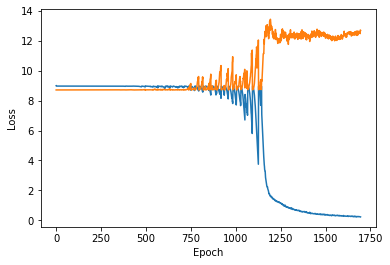

In [11]:
# Plot epoch loss to test for convergence
plt.plot(epoch_loss_averages)
plt.plot(test_epoch_loss_averages)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()